In [1]:
import sys
sys.path.append("/data1/andrew/meng/mixehr/meng/VAE-EHR/src")
from importlib import reload
import os

In [2]:
from typing import List, Tuple
from tsnecuda import TSNE
from umap import UMAP

import numpy as np 
import pandas as pd

import torch
from torch import nn, optim

import matplotlib.pyplot as plt

In [3]:
import vae
reload(vae)

from vae import VAE
from vae import VAETrainer

In [4]:
patient_icd_file = "/data1/andrew/meng/mixehr/data/Mimic/andrew_outputs/PATIENT_ICD_BINARY.csv"
patient_icd_df = pd.read_csv(patient_icd_file, sep=' ')

patient_icd_data = patient_icd_df.drop('SUBJECT_ID', axis=1)
data = torch.tensor(patient_icd_data.values).float()
print(data.shape)

torch.Size([46520, 6984])


In [5]:
def tsne_embedding(X):
    return TSNE(n_components=2, perplexity=15, learning_rate=10).fit_transform(X)

def umap_embedding(X):
    return UMAP().fit_transform(X)

def plot2d(X, filename, colors=None):
    plt.figure(figsize=(8,5))
    plt.scatter(
        x=X[:, 0], 
        y=X[:, 1],
        c=colors, 
        cmap='cool', 
        alpha=0.05
    )
    plt.xlabel('tsne-one')
    plt.ylabel('tsne-two')
    plt.colorbar()
    
    plt.savefig("{}.png".format(filename))
    plt.show()

In [6]:
mimic_root_path = "/data1/andrew/meng/mixehr/data/Mimic/mimic-iii-clinical-database-1.4"
icd9codes_path = os.path.join(mimic_root_path, "D_ICD_DIAGNOSES.csv.gz")
icd9codes = pd.read_csv(icd9codes_path)

#Used for DISEASE clustering
def get_icd_idxs(
    patient_icd_df: pd.DataFrame, 
    substrings: List[str], 
    case_sensitive: bool=True, 
    verbose: bool=False):
    
    idxs = []
    for substring in substrings:
        icds_with_substring = icd9codes[icd9codes.LONG_TITLE.str.contains(substring, case=case_sensitive)].ICD9_CODE.tolist()
        print("Occurences of {0} before filter: {1}".format(substring, len(icds_with_substring)))
        
        icds_with_substring_and_in_patient_icd_df = [icd for icd in icds_with_substring if icd in patient_icd_df.columns]
        icds_with_substring=icds_with_substring_and_in_patient_icd_df
        print("After:", len(icds_with_substring))

        idx = [patient_icd_df.columns.get_loc(icd) - 1 for icd in icds_with_substring]
        idxs += idx
    
    if verbose:
        print(icd9codes[icd9codes.SHORT_TITLE.str.contains(substring, case=case_sensitive)])
    print("Total found: {}".format(len(idxs)))
    return idxs

#Use for PATIENT clustering
def get_patients_idxs_with_disease_keywords(
    patient_icd_df: pd.DataFrame,
    substrings: List[str],
    case_sensitive: bool=False,
    verbose: bool=False
    ):
    
    idxs = []
    relevant_icds = []
    for substring in substrings:
        icds_with_substring = icd9codes[icd9codes.LONG_TITLE.str.contains(substring, case=case_sensitive)].ICD9_CODE.tolist()
        print("Occurences of {0} before filter: {1}".format(substring, len(icds_with_substring)))

        icds_with_substring_and_in_patient_icd_df = [icd for icd in icds_with_substring if icd in patient_icd_df.columns]
        icds_with_substring=icds_with_substring_and_in_patient_icd_df        
        print("After:", len(icds_with_substring))
        
        relevant_icds += icds_with_substring_and_in_patient_icd_df
        
    print("Total Relevant ICDs: {}".format(len(relevant_icds)))
    patients_with_disease = patient_icd_df.loc[:, relevant_icds].any(axis=1)
    patients_with_disease = patients_with_disease[patients_with_disease == True]
    print("Patients with disease(s): {}".format(len(patients_with_disease)))
    
    return patients_with_disease.index.tolist()

def most_common_diseases_in_cohort(
    patient_icd_df: pd.DataFrame,
    patient_idxs: List[int]
    ):
    patients_of_interest = patient_icd_df.drop('SUBJECT_ID', axis=1).iloc[patient_idxs]
    disease_sums = patients_of_interest.sum(axis=0)
    return disease_sums.sort_values(ascending=False)

def lookup_icds(
    icd9codes_df: pd.DataFrame,
    icd9codes_list: List[str]
    ):
    return icd9codes_df[icd9codes_df['ICD9_CODE'].isin(icd9codes_list)]

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print((device))

print("Feature_dim: {}".format(data.shape[1]))
model = VAE(
    feature_dim = data.shape[1], 
    encoder_dim = [(250, 500), (500, 250), (250, 100)],
    latent_dim = 10,
    decoder_dim = [], 
    use_relu=False
)

optimizer = optim.Adam(model.parameters(), lr=0.001)
print(type(optimizer))

cuda
Feature_dim: 6984
<class 'torch.optim.adam.Adam'>


In [18]:
date="200110"
experiment_name = "{}_patient_clusters_linear_encoder_single_layer_decoder".format(date)
epoch = 10
tag = ""
model.load_state_dict(torch.load("./VAE_exp_{}_epoch_{}.pkl".format(experiment_name, epoch)))

<All keys matched successfully>

In [19]:
trainer = VAETrainer(
    model=model, 
    device=device, 
    optimizer=optimizer,
    experiment_name=experiment_name
)

In [20]:
print(data.shape)

torch.Size([46520, 6984])


In [21]:
latent, _, _ = trainer.encode_data(data)
X_tsne = tsne_embedding(latent.cpu().detach().numpy())

In [22]:
heart_keywords = ['heart', 'atrial', 'coronary', 'hypertension', 'vascular']
heart_patient_idxs = get_patients_idxs_with_disease_keywords(patient_icd_df, heart_keywords, False, True)

#lookup_icds(icd9codes, ["4019", "41401"])

Occurences of heart before filter: 97
After: 77
Occurences of atrial before filter: 4
After: 4
Occurences of coronary before filter: 21
After: 18
Occurences of hypertension before filter: 61
After: 27
Occurences of vascular before filter: 116
After: 85
Total Relevant ICDs: 211
Patients with disease(s): 29510


In [23]:
heart_colors = np.array([0 for i in range(X_tsne.shape[0])])
heart_colors[heart_patient_idxs] = 100

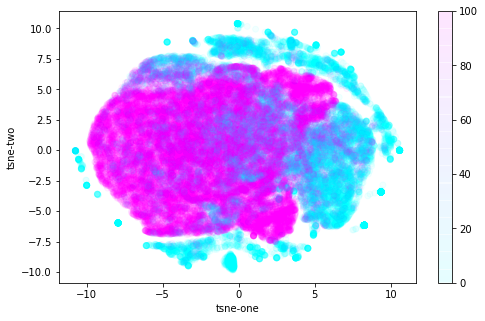

In [24]:
plot2d(
    X=X_tsne, 
    filename="Patient_Clusters_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_heart"), 
    colors=heart_colors,
)

In [25]:
baby_keywords = ['congenital', 'infant', 'newborn', 'neonatal', 'born', 'birth']
baby_patient_idxs = get_patients_idxs_with_disease_keywords(patient_icd_df, baby_keywords, case_sensitive=False)

Occurences of congenital before filter: 167
After: 86
Occurences of infant before filter: 38
After: 21
Occurences of newborn before filter: 117
After: 77
Occurences of neonatal before filter: 21
After: 18
Occurences of born before filter: 195
After: 94
Occurences of birth before filter: 173
After: 39
Total Relevant ICDs: 335
Patients with disease(s): 8665


In [26]:
baby_heart_colors = np.array([0 for i in range(X_tsne.shape[0])])
baby_heart_colors[heart_patient_idxs] = 100
baby_heart_colors[baby_patient_idxs] = 50

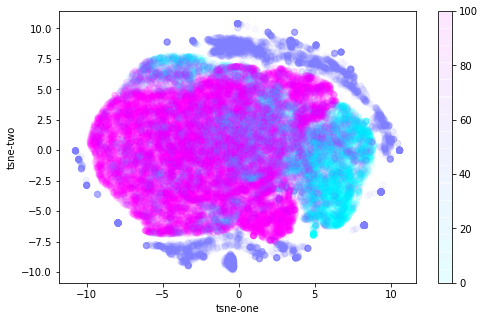

In [27]:
plot2d(X_tsne, "Patient_Clusters_exp_{}_epoch_{}{}".format(experiment_name, epoch, "_baby_heart"), colors=baby_heart_colors)